#**Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Embedding, Flatten, Dropout,Bidirectional
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#**1-  Exploratory Data Analysis**

##**1-1 Import Data**
Yelp reviews - Polarity
- training set
- test set

In [ ]:
# import data
!wget -nc https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
!tar xvzf yelp_review_polarity_csv.tgz
%cd yelp_review_polarity_csv/

--2021-01-12 14:26:14--  https://s3.amazonaws.com/fast-ai-nlp/yelp_review_polarity_csv.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.8.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.8.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166373201 (159M) [application/x-tar]
Saving to: ‘yelp_review_polarity_csv.tgz’

yelp_review_polarit 100%[===================>] 158.67M  63.7MB/s    in 2.5s    

2021-01-12 14:26:17 (63.7 MB/s) - ‘yelp_review_polarity_csv.tgz’ saved [166373201/166373201]

yelp_review_polarity_csv/
yelp_review_polarity_csv/train.csv
yelp_review_polarity_csv/readme.txt
yelp_review_polarity_csv/test.csv
/content/yelp_review_polarity_csv/yelp_review_polarity_csv


##**1-2 Read Data**
CSV to dataframe\
Set variables' name:
- "lablel" : class of review
 - 1 = negative
 - 2 = positive
- "text" : content of review

In [ ]:
yelp_review_train = pd.read_csv("train.csv", header=None, names=["label", "text"])
yelp_review_test = pd.read_csv("test.csv", header=None, names=["label", "text"])

In [ ]:
yelp_review_train.head(n=3)

,label,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...


In [ ]:
print('train set sample size:\t n = ',len(yelp_review_train))
print('train set labels:\t', np.unique(yelp_review_train.label))

train set sample size:	 n =  560000
train set labels:	 [1 2]


In [ ]:
yelp_review_test.head(n=3)

,label,text
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."


In [ ]:
print('test set sample size:\t n = ',len(yelp_review_test))
print('test labels:\t', np.unique(yelp_review_test.label))

test set sample size:	 n =  38000
test labels:	 [1 2]


##**1-3 Evaluate Missing Values**

In [ ]:
#train set
empty_train_text = [index for index,text in enumerate(yelp_review_train.text.values) 
if str(text).strip() == '']
empty_train_label = yelp_review_train.label.isnull().sum()

# test set
empty_test_text = [index for index,text in enumerate(yelp_review_test.text.values) 
if str(text).strip() == '']
empty_test_label = yelp_review_test.label.isnull().sum()

print('dataset \t Filed \t\t Missing')
print('train \t\t text \t\t', len(empty_train_text))
print('train \t\t label \t\t', empty_train_label)
print('test \t\t text \t\t', len(empty_test_text))
print('test \t\t label \t\t', empty_test_label)

dataset 	 Filed 		 Missing
train 		 text 		 0
train 		 label 		 0
test 		 text 		 0
test 		 label 		 0


##**1-4 Evaluate Class Balance**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


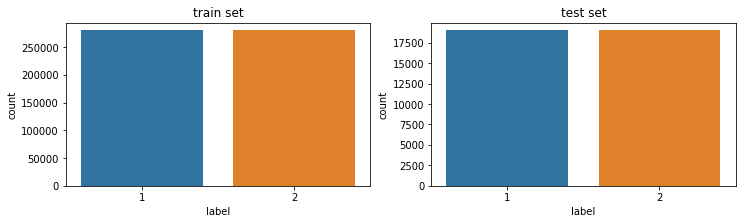

In [ ]:
fig = plt.figure(figsize=(12,3))
ax1=fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(122)
sns.countplot("label", data=yelp_review_train, ax=ax1).set(title='train set')
sns.countplot("label", data=yelp_review_test, ax=ax2).set(title='test set')
plt.show()

##**1-5 Visualization - Word Could**

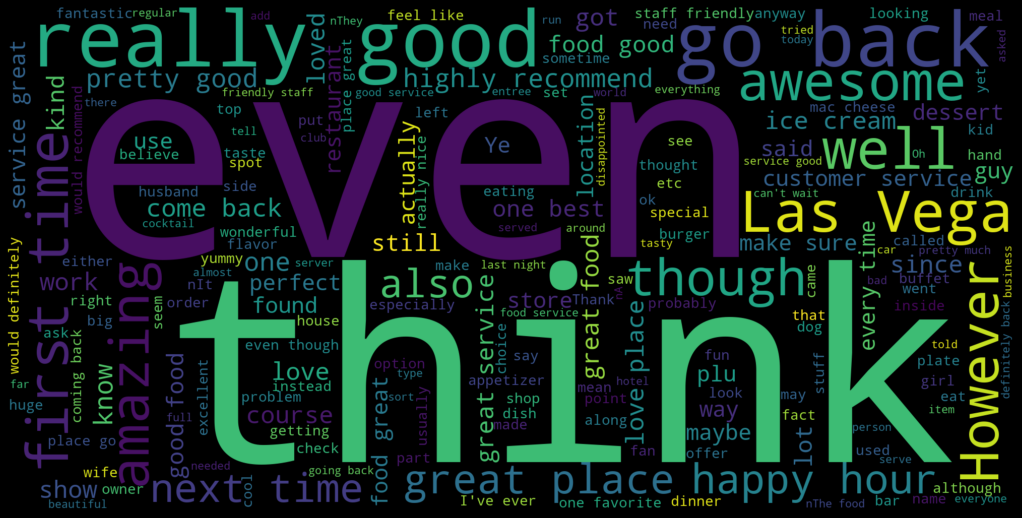

In [ ]:
# positive reviews
positive= yelp_review_train[yelp_review_train.label.eq(2)]

text = ''
for news in positive.values:
    text += f" {news}"
wordcloud = WordCloud(width = 2000, height = 1000, background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(figsize = (16, 7), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

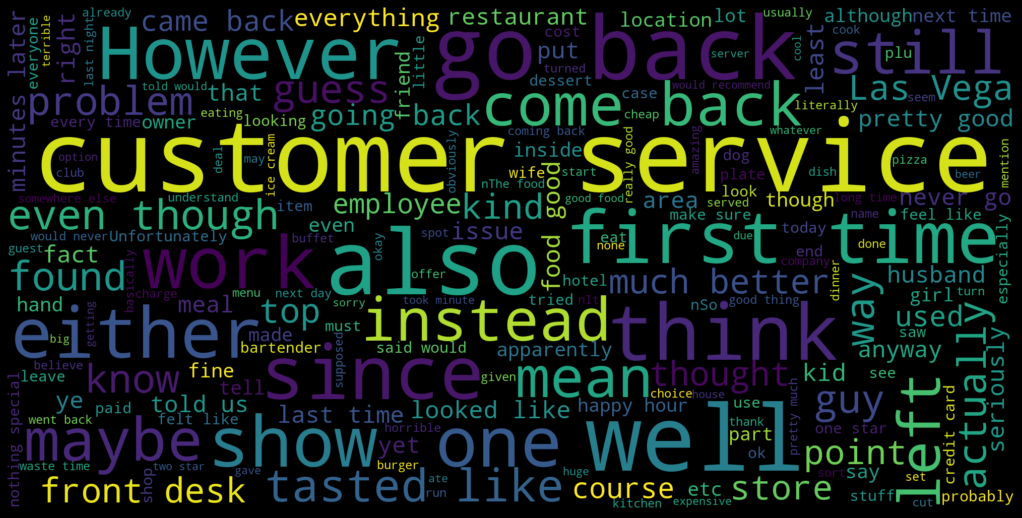

In [ ]:
# negative reviews
negative= yelp_review_train[yelp_review_train.label.eq(1)]

text = ''
for news in negative.values:
    text += f" {news}"
wordcloud = WordCloud(width = 2000, height = 1000, background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(figsize = (16, 7), facecolor = 'k', edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#**2- Input Preparation**

##**2-1 Subset dataset**

In [ ]:
review_train = yelp_review_train.sample(frac=0.3, random_state=2021)
print(review_train.shape)

(168000, 2)


##**2-2 Define X and Y**

In [ ]:
# train set
x_train=yelp_review_train.text
y_train =yelp_review_train.label

# test set
x_test=yelp_review_test.text
y_test =yelp_review_test.label

##**2-3 Transform to Binary Class**

In [ ]:
# train set
y_train =y_train - 1

# test set
y_test =y_test - 1

In [ ]:
x_train.head()

0    Unfortunately, the frustration of being Dr. Go...
1    Been going to Dr. Goldberg for over 10 years. ...
2    I don't know what Dr. Goldberg was like before...
3    I'm writing this review to give you a heads up...
4    All the food is great here. But the best thing...
Name: text, dtype: object

In [ ]:
y_train.head()

0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64

##**2-4 Text Cleaning**
Removing StopWords, Punctuations and single-character words

In [ ]:
# before cleaning
x_train[0]

"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."

In [ ]:
def clean(x):
  M = []
  stop_words = set(nltk.corpus.stopwords.words("english"))
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  lemmatizer = nltk.WordNetLemmatizer() 
  for par in x:
      tmp = []
      sentences = nltk.sent_tokenize(par)
      for sent in sentences:
          sent = sent.lower()
          tokens = tokenizer.tokenize(sent)
          filtered_words = [w.strip() for w in tokens
                            if w not in stop_words and len(w) > 1 
                            and not w.isdigit()]
          tmp.extend(filtered_words)
          lem = ' '.join([lemmatizer.lemmatize(w) for w in tmp])
      M.append(lem)
  return (M)

x_train_clean =clean(x_train)
x_test_clean =clean(x_test)


# ______________________________________________________________________________
# from google.colab import drive
# drive.mount('/gdrive')

# x_train_clean = pd.read_csv("/gdrive/My Drive/clean_train.csv")
# https://drive.google.com/file/d/1yc2Qy0dZC4Coj9RwiDVENhNTGQSLPXyq/view?usp=sharing

# x_test_clean = pd.read_csv("/gdrive/My Drive/clean_train.csv")
# https://drive.google.com/file/d/1MDGXRl5_OHGDOt1pnBn1RyZFZwF_1udv/view?usp=sharing

In [ ]:
# after cleaning
x_train_clean[0]

'unfortunately frustration dr goldberg patient repeat experience many doctor nyc good doctor terrible staff seems staff simply never answer phone usually take hour repeated calling get answer time want deal run problem many doctor get office worker patient medical need anyone answering phone incomprehensible work aggravation regret feel give dr goldberg star'

##**2-5 Text to Vector**

Vectorizing the text corpus, by turning each
review text into a sequence of integers where each integer being the index of a token in a dictionary (based on the training set vocabulary list).

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_clean)
print('vocabulary size =', len(tokenizer.word_index))
# vocab_size = len(tokenizer.word_index) + 1

vocabulary size = 209526


Training set has a very large vocabulary size (209,526 unique words in corpus).\
In order to reduce run time, a lower vocabulary size is used for the next steps.


**with # & no lem= 224,754

In [ ]:
vocab_size = 10000
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train_clean)

Transforming each review  text to a sequence of integers. Only words known by the tokenizer will be taken into account.

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train_clean)
x_test = tokenizer.texts_to_sequences(x_test_clean)

In [ ]:
list(tokenizer.word_index.items())[0:10]

[('place', 1),
 ('food', 2),
 ('good', 3),
 ('time', 4),
 ('like', 5),
 ('get', 6),
 ('one', 7),
 ('service', 8),
 ('would', 9),
 ('great', 10)]

In [ ]:
np.array(x_train[0])

array([ 568, 3583,  789, 1095, 1806,   55,  111,  925, 2278,    3,  925,
        348,   58,  401,   58,  672,   22,  922,  305,  281,   60,   67,
       3646, 1226,    6,  922,    4,   61,  264,  400,  257,  111,  925,
          6,  497,  814, 1095, 2571,   97,  358, 3776,  305,  110, 9250,
       1867,  136,   78,  789,   68])

##**2-6 Padding**

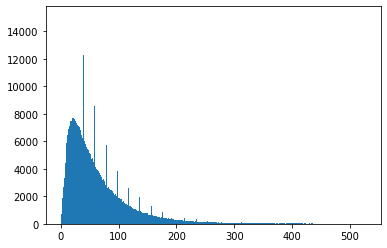

In [ ]:
# Evaluate review length after cleaning
plt.hist([len(x) for x in x_train], bins=500)
plt.show()

In [ ]:
myx = np.array([len(x) for x in x_train])
print('\n',round(100 *len(myx[myx < 200])/len(x_train),1), 
      '% of reviews have less than 200 words')
print('\n longest review has', max(myx), 'words')


 96.5 % of reviews have less than 200 words

 longest review has 527 words


In [ ]:
# apply padding with max length of 200
maxlen = 200
x_train = sequence.pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

In [ ]:
x_train[1]

array([  47,  789,   91,   64,    7, 1797, 1095,  308,   10,   91,   13,
        130,  644, 2735,  789,  174,  256, 1095, 2755, 2481, 2109,   70,
        562, 3093,   61,  468, 5414,  114, 2713, 2571, 1405,  449,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

#**3- Model Training**
1- Sequential input: Temporal dependency between words in a review

2- Different input length

3- Long text inputs (200 words after truncation): Long term dependencies

4- Binary output

**=> Sequential Neural Network with Many–to–One Recurrent Architecture and LSTM layer**
- Positive  review\
![picture](https://drive.google.com/uc?id=1hG0kTg4dU5Jw_QE0mkJAgT56dt0DC8ZZ)

- Negative  review\
![picture](https://drive.google.com/uc?id=16iOc2wamVldrRWEYJXF07CE_hhql_P2Q)






In [ ]:
# Embedding Output Dimension
dim = 64

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [ ]:
# Plot training history

def history_plt(history):

  history_dict = history.history
  acc = history_dict['acc']
  val_acc = history_dict['val_acc']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']
  epochs = history.epoch

  plt.figure(figsize=(20,6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, 'g', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss', size=15)
  plt.xlabel('Epochs', size=15)
  plt.ylabel('Loss', size=15)
  plt.legend(prop={'size': 15})

  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'g', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy', size=15)
  plt.xlabel('Epochs', size=15)
  plt.ylabel('Accuracy', size=15)
  plt.legend(prop={'size': 15})
  plt.ylim((0.5,1))

  return plt.show()

##**3-1 Model 1: RNN**
- one Embedding layer
- one RNN layer
- one Dropout layer
- one Dense layer

In [ ]:
model_1 = Sequential([Embedding(vocab_size, dim, mask_zero=True),
                   SimpleRNN(64),
                   Dropout(0.3),
                   Dense(1, activation='sigmoid')
                   ])
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 648,321
Trainable params: 648,321
Non-trainable params: 0
_________________________________________________________________


###**3-1-1 Fit RNN on training data**

In [ ]:
history_1 = model_1.fit(x_train, y_train, epochs=3, validation_split=0.3, callbacks=[early_stop])

Epoch 1/5
12250/12250 [==============================] - 862s 70ms/step - loss: 0.3606 - acc: 0.8378 - val_loss: 0.3243 - val_acc: 0.8700
Epoch 2/5
12250/12250 [==============================] - 861s 70ms/step - loss: 0.3462 - acc: 0.8571 - val_loss: 0.3329 - val_acc: 0.8691


###**3-1-2 RNN Learning progress**
 
 Variation of accuracy and loss at different epochs

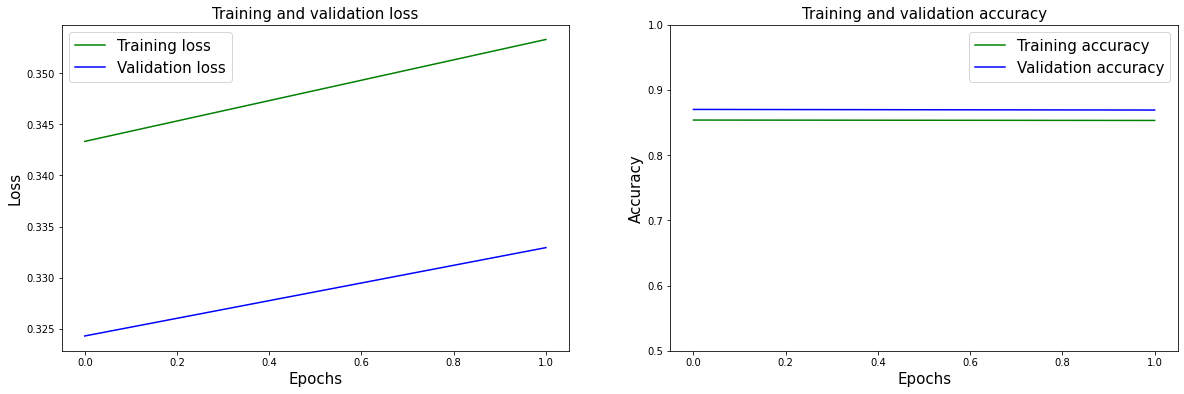

In [ ]:
history_plt(history_1)

##**3-2 Model 2: LSTM**

- one Embedding layer
- one LSTM layer
- one Dense layer


In [ ]:
model_2 = Sequential([Embedding(vocab_size, dim, mask_zero=True),
                   LSTM(128),
                   Dense(1, activation='sigmoid')
                   ])
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_2.summary()

###**3-2-1 Fit LSTM on Training Data**

In [ ]:
history_2 = model_2.fit(x_train, y_train, epochs=10,validation_split=0.2, callbacks=[early_stop]) 

Epoch 1/10
12250/12250 [==============================] - 199s 16ms/step - loss: 0.2551 - acc: 0.8939 - val_loss: 0.1588 - val_acc: 0.9382
Epoch 2/10
12250/12250 [==============================] - 199s 16ms/step - loss: 0.1589 - acc: 0.9382 - val_loss: 0.1493 - val_acc: 0.9404
Epoch 3/10
12250/12250 [==============================] - 198s 16ms/step - loss: 0.1316 - acc: 0.9489 - val_loss: 0.1492 - val_acc: 0.9418
Epoch 4/10
12250/12250 [==============================] - 199s 16ms/step - loss: 0.1089 - acc: 0.9588 - val_loss: 0.1647 - val_acc: 0.9414


###**3-2-2 LSTM Learning Progress**
 
 Variation of accuracy and loss at different epochs

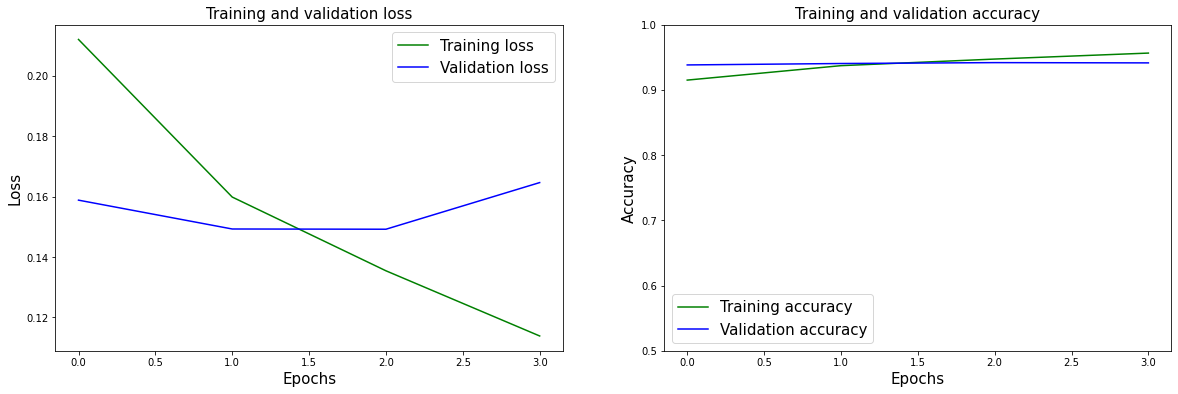

In [ ]:
history_plt(history_2)

##**3-3 Model 3: Bidirectional**

- one Embedding layer
- two Bidirectional LSTM layers
- one Dropout layer
- two Dense layers

In [ ]:
model_3a = Sequential([
    Embedding(vocab_size, dim, mask_zero=True),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
    ])

model_3a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_3a.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 837,889
Trainable params: 837,889
Non-trainable params: 0
_________________________________________________________________


###**3-3-1 Fit Bidirectional on Training Data**

In [ ]:
history_3a = model_3a.fit(x_train, y_train, validation_split=0.3, epochs=ep, callbacks=[early_stop])

Epoch 1/3
12250/12250 [==============================] - 488s 40ms/step - loss: 0.5293 - acc: 0.7850 - val_loss: 0.3083 - val_acc: 0.9028
Epoch 2/3
12250/12250 [==============================] - 484s 39ms/step - loss: 0.4722 - acc: 0.8231 - val_loss: 0.2899 - val_acc: 0.9051
Epoch 3/3
12250/12250 [==============================] - 481s 39ms/step - loss: 0.3452 - acc: 0.8934 - val_loss: 0.2965 - val_acc: 0.9258


In [ ]:
history_3a = model_3a.fit(x_train, y_train, validation_split=0.1, epochs=1, callbacks=[early_stop])

15750/15750 [==============================] - 6366s 404ms/step - loss: 0.2335 - acc: 0.9050 - val_loss: 0.1400 - val_acc: 0.9468


###**3-3-2 Bidirectional Learning Progress**
 
 Variation of accuracy and loss at different epochs

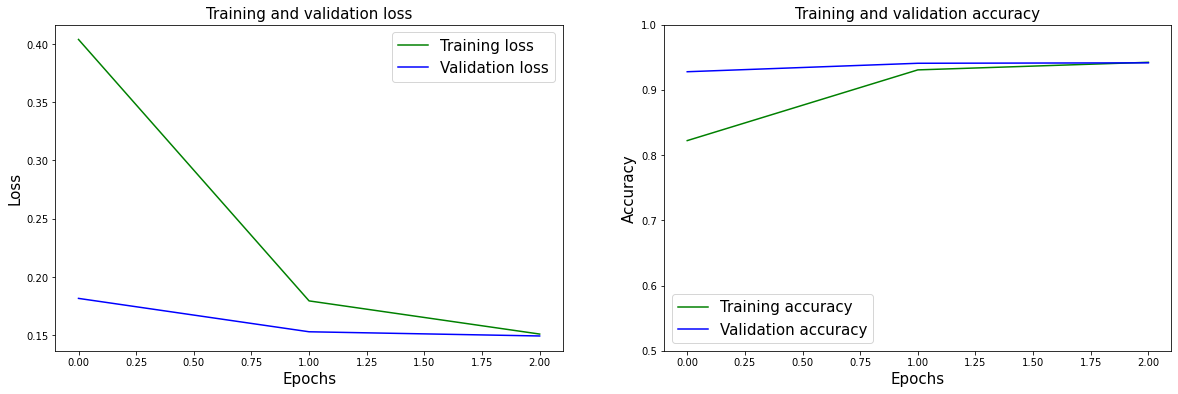

In [ ]:
history_plt(history_3a)

In [ ]:
model_3b = Sequential([
    Embedding(vocab_size, dim, mask_zero=True),
    Bidirectional(LSTM(64,  return_sequences=True)),
    Bidirectional(LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
    ])

model_3b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_3b.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 50)          500000    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 200)         120800    
_________________________________________________________________
dense_21 (Dense)             (None, None, 64)          12864     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
dense_22 (Dense)             (None, None, 1)           65        
Total params: 633,729
Trainable params: 633,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_3b = model_3b.fit(x_train, y_train, validation_split=0.3, epochs=ep, callbacks=[early_stop])

Epoch 1/10
12250/12250 [==============================] - 317s 26ms/step - loss: 0.4360 - acc: 0.7974 - val_loss: 0.1767 - val_acc: 0.9312
Epoch 2/10
12250/12250 [==============================] - 312s 25ms/step - loss: 0.1788 - acc: 0.9311 - val_loss: 0.1583 - val_acc: 0.9385
Epoch 3/10
12250/12250 [==============================] - 313s 26ms/step - loss: 0.1459 - acc: 0.9441 - val_loss: 0.1546 - val_acc: 0.9410
Epoch 4/10
12250/12250 [==============================] - 315s 26ms/step - loss: 0.1230 - acc: 0.9536 - val_loss: 0.1531 - val_acc: 0.9414
Epoch 5/10
12250/12250 [==============================] - 315s 26ms/step - loss: 0.1020 - acc: 0.9620 - val_loss: 0.1648 - val_acc: 0.9401


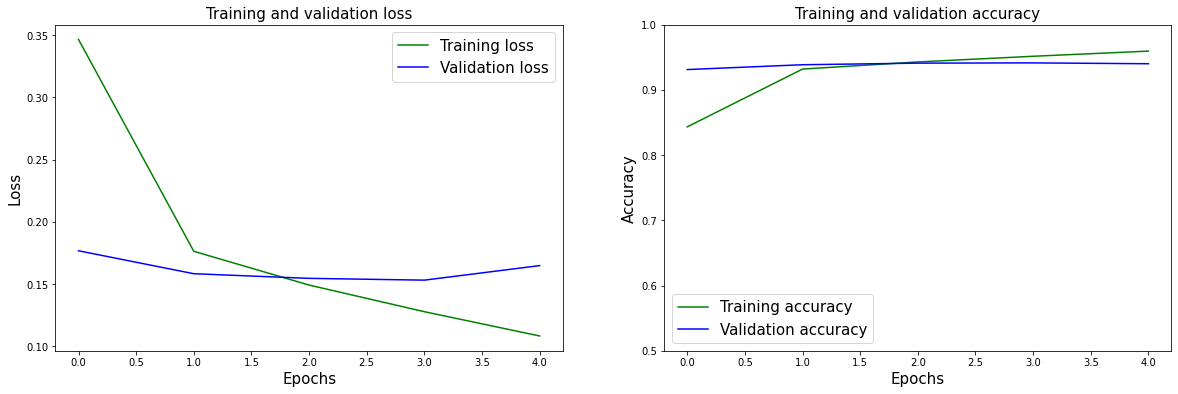

In [ ]:
history_plt(history_3b)

In [ ]:
model_3c = Sequential([
    Embedding(vocab_size, dim, mask_zero=True),
    Bidirectional(LSTM(100,  return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
    ])

model_3c.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model_3c.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 50)          500000    
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 200)         120800    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 128)               135680    
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 760,641
Trainable params: 760,641
Non-trainable params: 0
________________________________________________

In [ ]:
history_3c = model_3c.fit(x_train, y_train, validation_split=0.3, epochs=ep, callbacks=[early_stop])

In [ ]:
history_plt(history_3c)

##**3-4 Model 4: Flatten**

- one Embedding layer
- one Flatten layer
- one Dropout layer
- two Dense layers

In [ ]:
# model_4 = Sequential([Embedding(vocab_size, dim),
#                     Flatten(),
#                     Dropout(rate=0.4),
#                     Dense(100, activation='relu'),
#                     Dense(1, activation='sigmoid')])
# model_4.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# model_4.summary()

###**3-4-1 Fit Flatten on training data**

In [ ]:
# history_4= model_4.fit(x_train, y_train, epochs=ep, validation_split=0.3, callbacks=[early_stop])

#**4- Model Selection**

Select the best performing model.

In [ ]:
Best_model = model_2
history = history_2

#**5- Forecast**
Predict labels on test set with selected model 

Accuracy on test set =  93.67 %

              precision    recall  f1-score   support

           0       0.94      0.93      0.94     19000
           1       0.93      0.95      0.94     19000

    accuracy                           0.94     38000
   macro avg       0.94      0.94      0.94     38000
weighted avg       0.94      0.94      0.94     38000



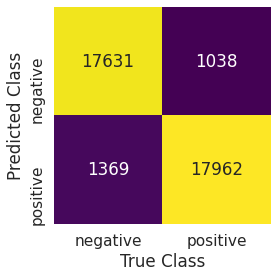

In [ ]:
pred = (Best_model.predict(x_test) >= 0.5).astype("int")

mat = confusion_matrix(y_test, pred)
sns.set(font_scale=1.4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='viridis',
            xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.xlabel('True Class')
plt.ylabel('Predicted Class')

print("Accuracy on test set = ", 100*round(accuracy_score(y_test, pred),4), '%\n')
print(classification_report(y_test, pred))